# 1. Install Dependencies and Setup

In [1]:
!pip install tensorflow tensorflow-gpu opencv-python matplotlib
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout,BatchNormalization
import tensorflow as tf
import os
import cv2
import imghdr
import numpy as np
from matplotlib import pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout,BatchNormalization

In [2]:
from keras.applications.vgg16 import preprocess_input


In [3]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# 2. Map google Drive


In [5]:
#from google.colab import drive
#drive.mount('/content/drive/', force_remount=True)
#!cp -r 'drive/Othercomputers/KaiAIPC/KanisPC/nida/7202 deep learning/HW2/BuddhastatueData' '/content/data'

train_dir='data/train/'
validate_dir='data/validate/'
test_dir='data/test/'


In [6]:
import random
import numpy as np
import tensorflow as tf
seed=1111
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# 3. Load Data

In [7]:
img_w=256
img_h=256
num_classes = 8
my_batch_size=32


train_datagen_aug = ImageDataGenerator(
    rescale=1./255,
    #rotation_range=40,
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    #shear_range=0.2,
    #zoom_range=0.2,
    #brightness_range=(0.5,0.8),
    #horizontal_flip=True,
    preprocessing_function=preprocess_input)

validate_datagen_aug = ImageDataGenerator(
    rescale=1./255,
   preprocessing_function=preprocess_input)


train_generator_aug = train_datagen_aug.flow_from_directory(
    train_dir,
    target_size=(img_w, img_h),
    batch_size=my_batch_size,
    class_mode='categorical')

valid_generator_aug = validate_datagen_aug.flow_from_directory(
    validate_dir,
    target_size=(img_w, img_h),
    batch_size=my_batch_size,
    class_mode='categorical')





Found 1112 images belonging to 8 classes.
Found 368 images belonging to 8 classes.


# 6. Build Deep Learning Model

In [24]:

extractor = tf.keras.applications.vgg16.VGG16(weights = "imagenet", include_top=False, input_shape = (img_w, img_h, 3))

extractor.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [25]:
##Best Set
from tensorflow.keras import layers    
    
extractor.trainable = True
for i,layer in enumerate(extractor.layers):  
    layer.trainable=False


#b = extractor.get_layer('block5_conv1') 
#b.trainable = True 
#b = extractor.get_layer('block5_conv2') 
#b.trainable = True 
b = extractor.get_layer('block5_conv3') 
b.trainable = True 






data_augmentation = Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.Normalization(),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.1),
        layers.RandomContrast(factor=0.1),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ]
)

model = Sequential()   
model.add(data_augmentation)
model.add(extractor)


# Add our custom layer(s) to the end of the existing model 

#model.add(Conv2D( filters=32, kernel_size=(5,5), strides=(1,1), padding="same", activation='relu', name='our_conv1' ) )
#model.add(Dropout(0.1))
#model.add(Conv2D( filters=32, kernel_size=(3,3), strides=(1,1), padding="same", activation='relu', name='our_conv2' ) )
#model.add(Conv2D(32, (3,3), 1, activation='relu'))
#model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.4))

model.add(Dense(128,activation='relu'))
model.add(Dropout(0.4))

model.add(Dense(64,activation='relu'))


model.add(Dense(units=num_classes, activation="softmax"))
model.compile('adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.build((None,img_w,img_h,3))
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 256, 256, 3)       7         
                                                                 
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 32768)             0         
                                                                 
 dense_8 (Dense)             (None, 512)               16777728  
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_9 (Dense)             (None, 128)               65664     
                                                                 
 dropout_5 (Dropout)         (None, 128)              

# 7. Train

In [26]:
logdir='logsvgg16'

In [27]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [28]:
import time
start_time = time.time()
hist = model.fit(train_generator_aug,epochs=20, validation_data=valid_generator_aug, callbacks=[tensorboard_callback])
end_time = time.time()
print('####################################')
print('#  Training time = %s seconds ---' % (end_time - start_time))

Epoch 1/20
35/35 [==============================] - 9s 201ms/step - loss: 2.1887 - accuracy: 0.1987 - val_loss: 1.7006 - val_accuracy: 0.3859
Epoch 2/20
35/35 [==============================] - 7s 195ms/step - loss: 1.6358 - accuracy: 0.3903 - val_loss: 1.4196 - val_accuracy: 0.4484
Epoch 3/20
35/35 [==============================] - 7s 203ms/step - loss: 1.3425 - accuracy: 0.4910 - val_loss: 1.3203 - val_accuracy: 0.5679
Epoch 4/20
35/35 [==============================] - 7s 196ms/step - loss: 1.2302 - accuracy: 0.5450 - val_loss: 1.2021 - val_accuracy: 0.5978
Epoch 5/20
35/35 [==============================] - 7s 210ms/step - loss: 1.1054 - accuracy: 0.5962 - val_loss: 1.1583 - val_accuracy: 0.6630
Epoch 6/20
35/35 [==============================] - 7s 203ms/step - loss: 1.0296 - accuracy: 0.6385 - val_loss: 1.0880 - val_accuracy: 0.6223
Epoch 7/20
35/35 [==============================] - 7s 203ms/step - loss: 0.9625 - accuracy: 0.6556 - val_loss: 1.0380 - val_accuracy: 0.6957
Epoch 

# 8. Plot Performance

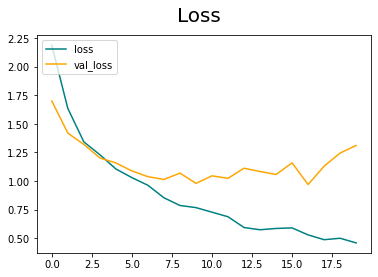

In [29]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

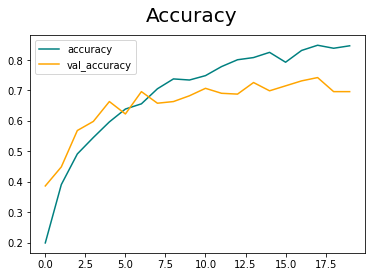

In [30]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# Evaluation


In [31]:

# evaluate model

test_datagen_aug = ImageDataGenerator(
    rescale=1./255,
   preprocessing_function=preprocess_input)

test_it = test_datagen_aug.flow_from_directory(test_dir, target_size=(img_w, img_h),
    batch_size=my_batch_size,
    class_mode='categorical')


start_time = time.time()

score = model.evaluate(test_it)

end_time = time.time()

print("Loss: ", score[0], "Accuracy: ", score[1])
print('####################################')
print('#  Inference time = %s seconds ---' % (end_time - start_time))




Found 372 images belonging to 8 classes.
12/12 [==============================] - 2s 180ms/step - loss: 1.0740 - accuracy: 0.7500
Loss:  1.074022650718689 Accuracy:  0.75
####################################
#  Inference time = 2.363434314727783 seconds ---


# 11. Save the Model

In [32]:
from tensorflow.keras.models import load_model

In [33]:
model.save(os.path.join('models','BuddhastatueDataimageclassifiervgg16.h5'))

In [34]:
new_model = load_model('models/BuddhastatueDataimageclassifiervgg16.h5')

ValueError: All `axis` values to be kept must have known shape. Got axis: (-1,), input shape: [None, None, None, None], with unknown axis at index: 3

In [ ]:
!nvidia-smi

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.utils.vis_utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)